<a href="https://colab.research.google.com/github/davenaman13/ML_MentalHealthRiskPrediction/blob/main/ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the uploaded file to inspect the data
file_path = 'survey.csv'
survey_data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset to understand its structure
survey_data.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [ ]:
survey_data.info()
survey_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

(1259, 27)

Since there are no missing values, the data is clean and ready for modeling.

Initial Insights

In [ ]:
# Standardize column names
survey_data.columns = survey_data.columns.str.lower().str.replace(' ', '_')

#  Inspect missing values
missing_values = survey_data.isnull().sum()

# Identify unique values in categorical columns for standardization
categorical_columns = survey_data.select_dtypes(include=['object']).columns
unique_values = {col: survey_data[col].unique() for col in categorical_columns}

# Display missing values and unique values for initial insights
missing_values, unique_values


(timestamp                       0
 age                             0
 gender                          0
 country                         0
 state                         515
 self_employed                  18
 family_history                  0
 treatment                       0
 work_interfere                264
 no_employees                    0
 remote_work                     0
 tech_company                    0
 benefits                        0
 care_options                    0
 wellness_program                0
 seek_help                       0
 anonymity                       0
 leave                           0
 mental_health_consequence       0
 phys_health_consequence         0
 coworkers                       0
 supervisor                      0
 mental_health_interview         0
 phys_health_interview           0
 mental_vs_physical              0
 obs_consequence                 0
 comments                     1095
 dtype: int64,
 {'timestamp': array(['2014-08-27 11:29:

**Standardized Column Names**:
Converting column names to lowercase and replacing spaces with underscores to ensure consistency and avoid errors during data manipulation.

Insights from Initial Exploration:

Missing Values:

Several columns have missing values, especially self_employed, state, and others. Some of these need appropriate imputation, while others may need to be dropped.

Categorical Variables:

Several categorical variables contain inconsistent values:
gender: Variants like "M", "Male", "male" exist.
Responses like "Don't know", "Maybe", and "Yes" need standardization.

Irrelevant Columns:

Columns like timestamp and comments are not directly useful for prediction and can be removed.

Age Outliers:

Age needs to be inspected for invalid or outlier values.

DATA CLEANING

In [ ]:
# 1. Drop irrelevant columns
survey_data = survey_data.drop(columns=['timestamp', 'comments'])

# 2: Handle missing values
# Fill 'self_employed' with 'No' (assumption: majority are not self-employed)
survey_data['self_employed'] = survey_data['self_employed'].fillna('No')

# Drop rows where 'state' or other critical columns (e.g., 'work_interfere') are missing
survey_data = survey_data.dropna(subset=['state', 'work_interfere'])

# 3: Standardize 'gender' column
survey_data['gender'] = survey_data['gender'].str.lower().str.strip()
gender_mapping = {
    'male': 'male', 'm': 'male', 'man': 'male',
    'female': 'female', 'f': 'female', 'woman': 'female',
    'other': 'non-binary/other', 'nb': 'non-binary/other', 'non-binary': 'non-binary/other'
}
survey_data['gender'] = survey_data['gender'].replace(gender_mapping)

# Replace uncommon or invalid entries with 'non-binary/other'
valid_genders = ['male', 'female', 'non-binary/other']
survey_data['gender'] = survey_data['gender'].apply(lambda x: x if x in valid_genders else 'non-binary/other')

# 4: Handle 'age' column
# Remove outliers (e.g., ages < 18 or > 100)
survey_data['age'] = pd.to_numeric(survey_data['age'], errors='coerce')  # Ensure 'age' is numeric
survey_data = survey_data[(survey_data['age'] >= 18) & (survey_data['age'] <= 100)]

# 5: Standardize other categorical variables
categorical_cols_to_clean = ['family_history', 'treatment', 'work_interfere', 'mental_health_consequence',
                             'phys_health_consequence', 'mental_vs_physical', 'obs_consequence']

for col in categorical_cols_to_clean:
    survey_data[col] = survey_data[col].str.lower().str.strip()

# 6: Fill remaining missing values with mode (for categorical variables)
survey_data.fillna(survey_data.mode().iloc[0], inplace=True) # Used mode since data is categorical and unique values are less in number

# Display cleaned data for review
survey_data.head()


,age,gender,country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,female,United States,IL,No,no,yes,often,6-25,No,...,Yes,Somewhat easy,no,no,Some of them,Yes,No,Maybe,yes,no
1,44,male,United States,IN,No,no,no,rarely,More than 1000,No,...,Don't know,Don't know,maybe,no,No,No,No,No,don't know,no
4,31,male,United States,TX,No,no,no,never,100-500,Yes,...,Don't know,Don't know,no,no,Some of them,Yes,Yes,Yes,don't know,no
5,33,male,United States,TN,No,yes,no,sometimes,6-25,No,...,Don't know,Don't know,no,no,Yes,Yes,No,Maybe,don't know,no
6,35,female,United States,MI,No,yes,yes,sometimes,1-5,Yes,...,No,Somewhat difficult,maybe,maybe,Some of them,No,No,No,don't know,no


**KEY TAKEAWAYS**

**Improved Data Consistency:**

Text data like gender and other categorical columns are now consistent and easier to analyze.

Numeric columns like age have been cleaned, removing outliers.

**Reduced Missing Values:**

Critical columns (state, work_interfere) retain only complete data, while others are filled with appropriate defaults (e.g., mode).

**Simplified Dataset:**

Irrelevant columns (timestamp, comments) are removed, focusing on meaningful features.

**Clean and Ready Data:**

The dataset is now clean, with no missing values or inconsistencies, and ready for further exploratory analysis, modeling, or visualization.

PERFORMING LABEL ENCODING

In [ ]:
# encoding for categorical variables
def encoding(column, mapping=None):
    #Encoding a categorical column using a mapping dictionary. If no mapping is provided, it assigns a unique integer to each unique value in the column.

    if mapping is None:
        unique_values = column.unique()
        mapping = {value: idx for idx, value in enumerate(unique_values)}
    encoded_column = column.map(mapping)
    return encoded_column, mapping

# Encoding all categorical columns manually
encoded_data = survey_data.copy()
encoding_mappings = {}

categorical_columns = encoded_data.select_dtypes(include=['object']).columns

for col in categorical_columns:
    encoded_data[col], encoding_mappings[col] = encoding(encoded_data[col])

# Display the first few rows of the encoded dataset and mappings
encoded_data.head(), encoding_mappings


(   age  gender  country  state  self_employed  family_history  treatment  \
 0   37       0        0      0              0               0          0   
 1   44       1        0      1              0               0          1   
 4   31       1        0      2              0               0          1   
 5   33       1        0      3              0               1          1   
 6   35       0        0      4              0               1          0   
 
    work_interfere  no_employees  remote_work  ...  anonymity  leave  \
 0               0             0            0  ...          0      0   
 1               1             1            0  ...          1      1   
 4               2             2            1  ...          1      1   
 5               3             0            0  ...          1      1   
 6               3             3            1  ...          2      2   
 
    mental_health_consequence  phys_health_consequence  coworkers  supervisor  \
 0                   

Why we Preferred Label Encoding Over One-Hot Encoding?

***Data Dimensionality***

**Label Encoding:** Replaces categorical values with integers, keeping the number of columns unchanged.

**One-Hot Encoding**: Creates a binary column for each category in a categorical variable. This significantly increases the number of columns, especially for features with many unique categories.

Reason for Choice:

Label Encoding is preferred as it avoids increasing dimensionality, which is important for datasets with a limited number of rows relative to features.


ALSO , Label Encoding works well for non-linear models (e.g., neural networks) and tree-based models because it allows the model to learn complex relationships between features without being constrained by the assumption of an inherent order between categories, and since we are using neural networks we preferred this.

EXPLORATORY DATA ANALYSIS

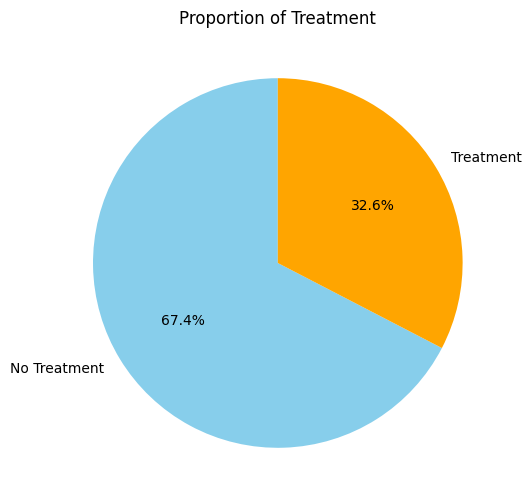

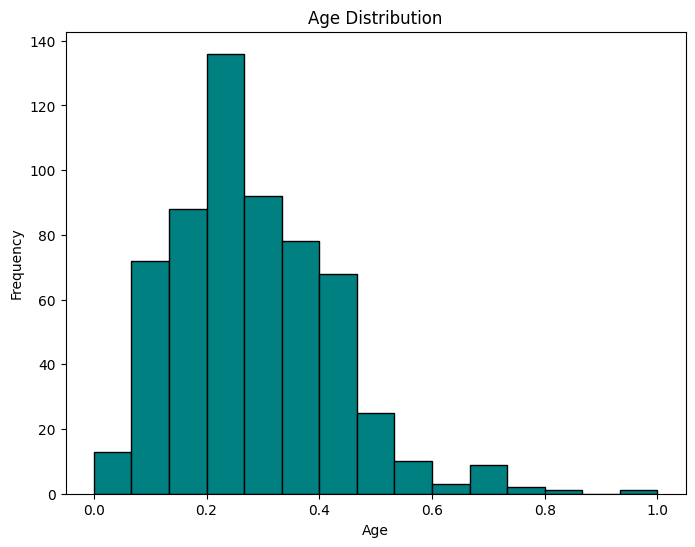

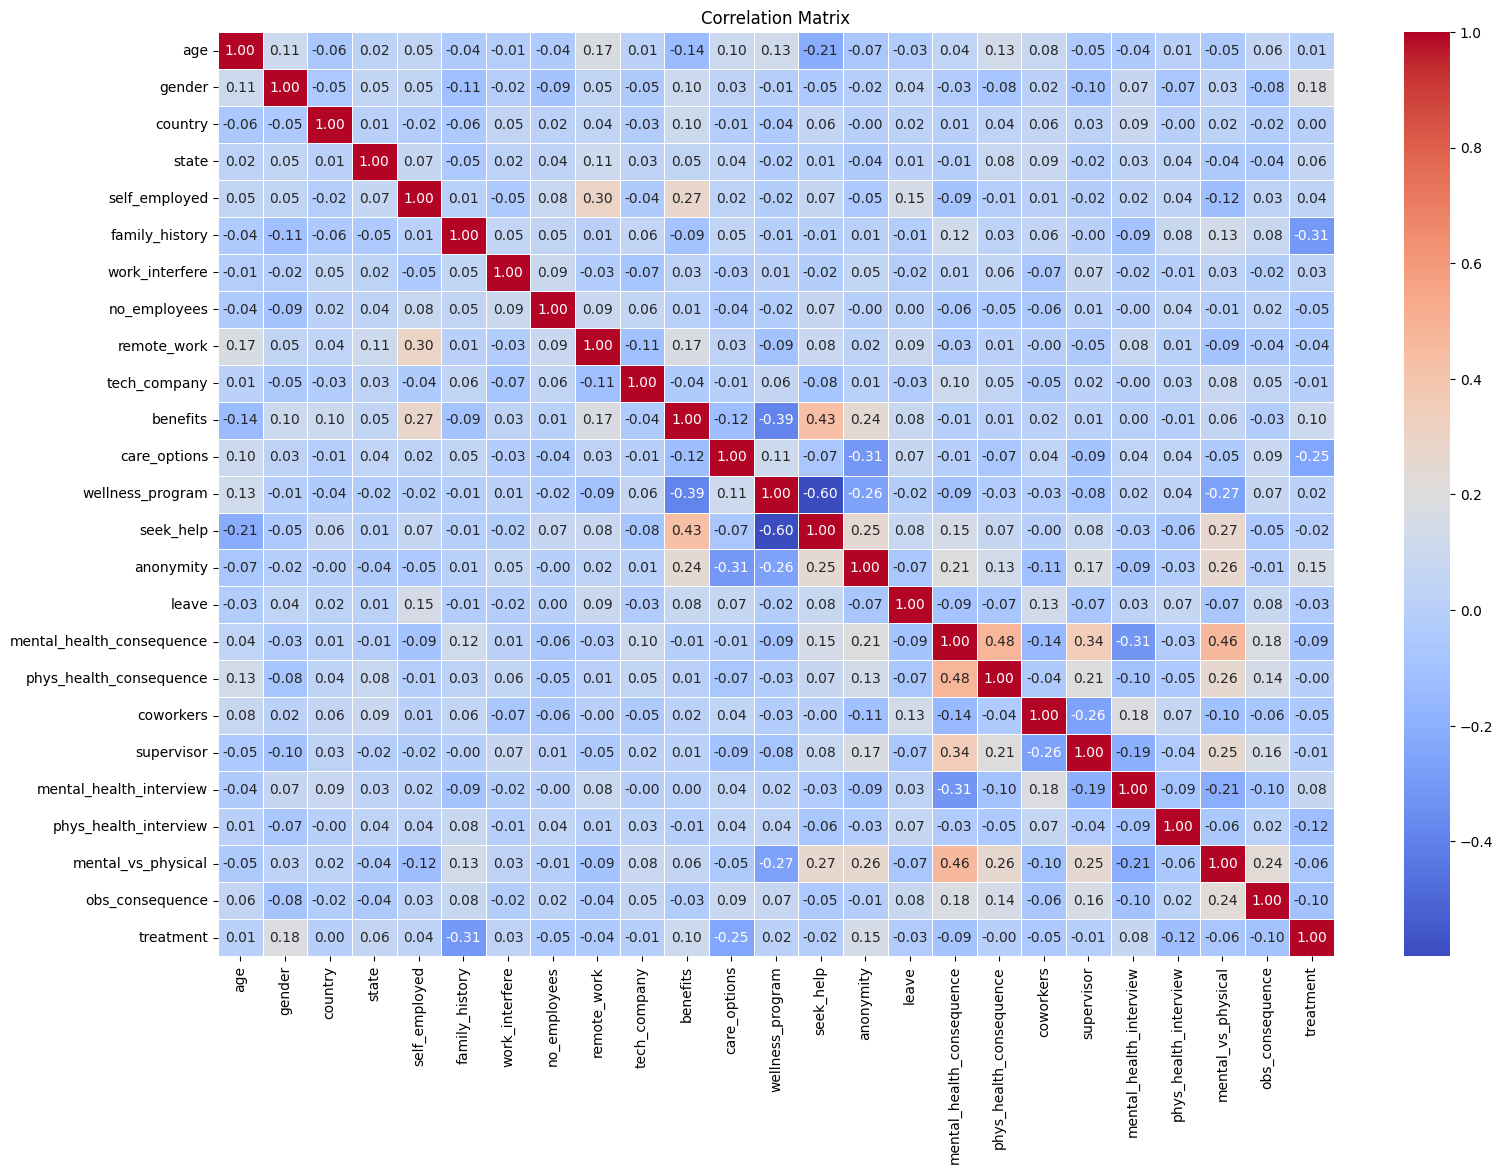

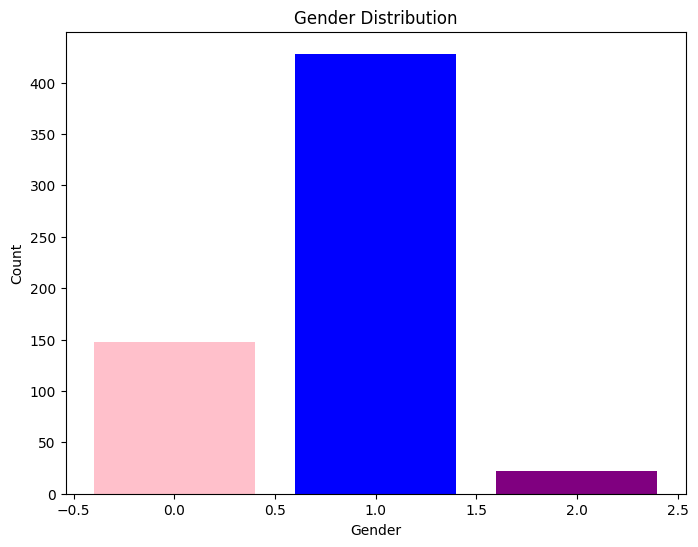

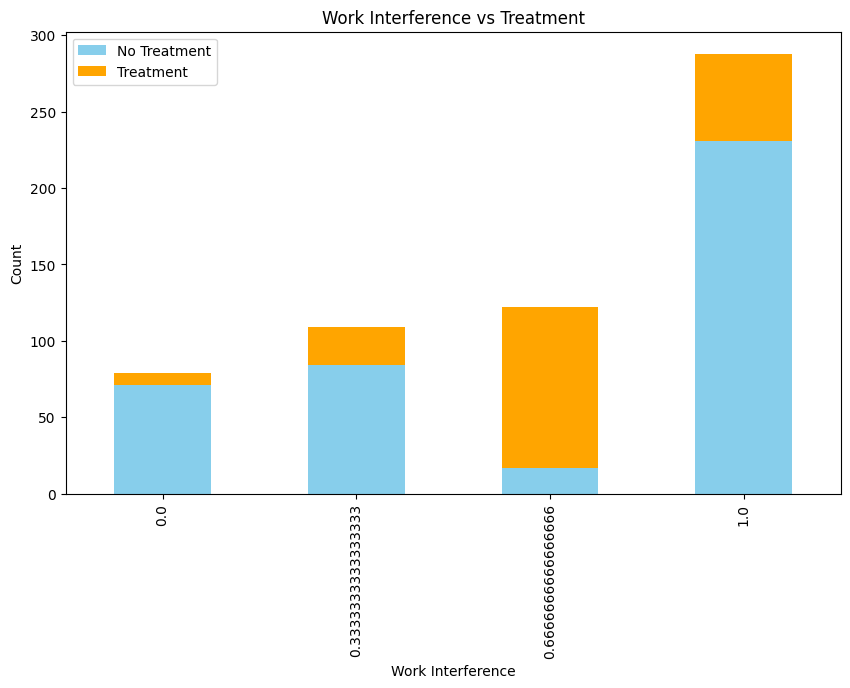

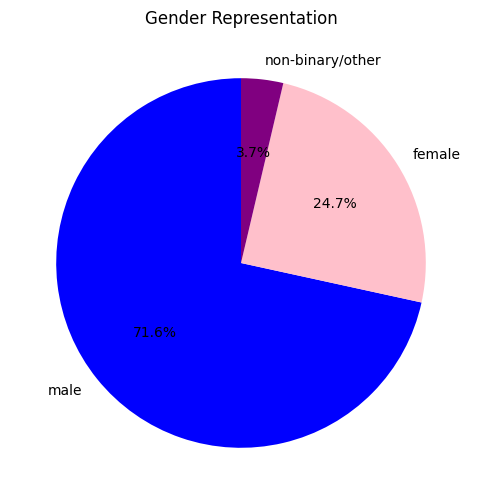

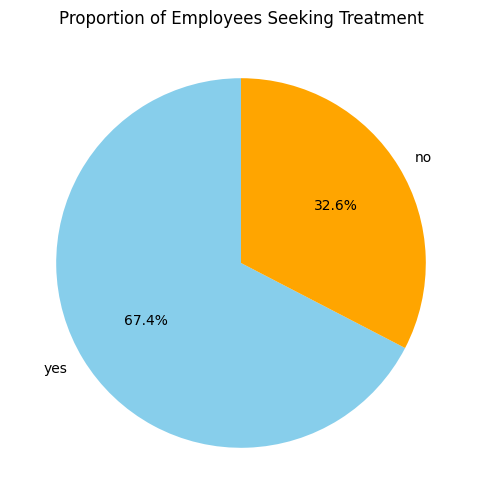

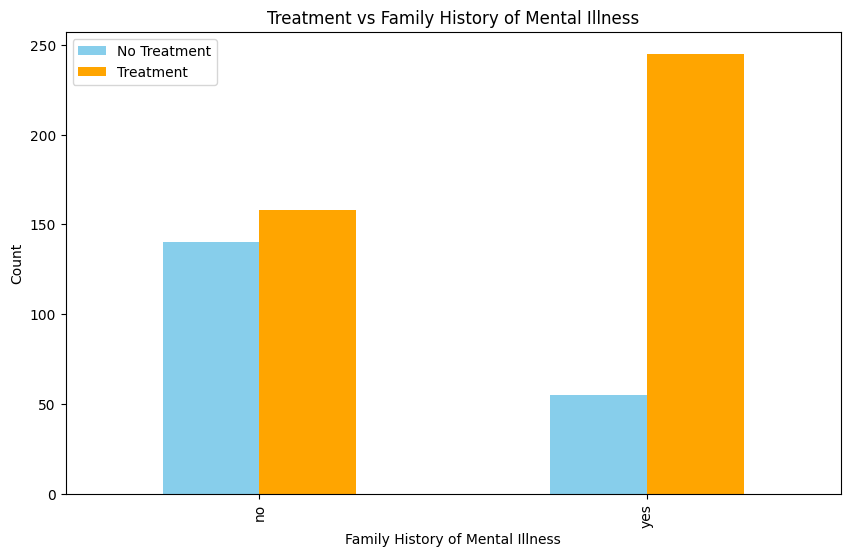

In [ ]:
  import matplotlib.pyplot as plt
  import seaborn as sns

  # Convert the encoded dataset back into a DataFrame for easier visualization
  eda_data = pd.DataFrame(X, columns=encoded_data.drop(columns=['treatment']).columns)
  eda_data['treatment'] = y

  # Pie chart for the target variable (treatment)
  treatment_counts = eda_data['treatment'].value_counts()
  plt.figure(figsize=(6, 6))
  plt.pie(
      treatment_counts,
      labels=['No Treatment', 'Treatment'],
      autopct='%1.1f%%',
      startangle=90,
      colors=['skyblue', 'orange']
  )
  plt.title('Proportion of Treatment')
  plt.show()

  # Histogram for Age
  plt.figure(figsize=(8, 6))
  plt.hist(eda_data['age'], bins=15, color='teal', edgecolor='black')
  plt.title('Age Distribution')
  plt.xlabel('Age')
  plt.ylabel('Frequency')
  plt.show()

  # Heatmap for correlations
  plt.figure(figsize=(18,12))
  correlation_matrix = eda_data.corr()
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
  plt.title('Correlation Matrix')
  plt.show()

  # Bar chart for gender distribution
  gender_counts = encoded_data['gender'].value_counts()
  plt.figure(figsize=(8, 6))
  plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink', 'purple'])
  plt.title('Gender Distribution')
  plt.xlabel('Gender')
  plt.ylabel('Count')
  plt.show()

  # Work interference vs treatment (stacked bar chart)
  work_interfere_treatment = eda_data.groupby(['work_interfere', 'treatment']).size().unstack()
  work_interfere_treatment.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange'])
  plt.title('Work Interference vs Treatment')
  plt.xlabel('Work Interference')
  plt.ylabel('Count')
  plt.legend(['No Treatment', 'Treatment'])
  plt.show()

  # Gender representation (Pie Chart)
  original_gender_counts = survey_data['gender'].value_counts()
  plt.figure(figsize=(6, 6))
  plt.pie(
      original_gender_counts,
      labels=original_gender_counts.index,
      autopct='%1.1f%%',
      startangle=90,
      colors=['blue', 'pink', 'purple']
  )
  plt.title('Gender Representation')
  plt.show()

  # Proportion of employees seeking treatment (Pie Chart)
  treatment_counts_original = survey_data['treatment'].value_counts()
  plt.figure(figsize=(6, 6))
  plt.pie(
      treatment_counts_original,
      labels=treatment_counts_original.index,
      autopct='%1.1f%%',
      startangle=90,
      colors=['skyblue', 'orange']
  )
  plt.title('Proportion of Employees Seeking Treatment')
  plt.show()

  # Treatment vs Family History of Mental Illness (Bar Graph)
  family_treatment = survey_data.groupby(['family_history', 'treatment']).size().unstack()
  family_treatment.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
  plt.title('Treatment vs Family History of Mental Illness')
  plt.xlabel('Family History of Mental Illness')
  plt.ylabel('Count')
  plt.legend(['No Treatment', 'Treatment'])
  plt.show()



**Overall Takeaways:**

Work interference, family history, and perceived consequences of
mental health issues are critical factors influencing whether employees seek treatment.

Gender and age significantly affect mental health representation and behavior in the workplace.

Employers and policymakers should focus on targeted interventions, de-stigmatization, and accessible mental health resources, especially in heavily represented age groups and countries.

**Applying Neural Networks to perform classification task on 'Treatment' needed or not**

In [ ]:
import numpy as np

# Prepare the dataset for neural network input
# Separate features and target variable
#'treatment' is the target variable (predicting if the employee seeks treatment)
X = encoded_data.drop(columns=['treatment']).values
y = encoded_data['treatment'].values

# Normalize the features
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))  #Scales all features to a range of 0 to 1 for faster convergence during training.

# Splitting the dataset into training and testing sets
def train_test_split(X, y, test_size=0.2, random_seed=42):
    np.random.seed(random_seed)
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_size)
    test_indices, train_indices = indices[:test_size], indices[test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Initializing the  neural network parameters
def initialize_parameters(input_size, hidden_size, output_size):   #Input layer: Size = number of features. Hidden layer: Size = hidden_size (10 units).Output layer: Size = 1 (binary classification).

    np.random.seed(42)
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))
    return W1, b1, W2, b2

# Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)

# Forward propagation
def forwardProp(X, W1, b1, W2, b2): #Computes the activations of the hidden layer (A1) and the output layer (A2).
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1) # Hidden Layer Activation
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2) # Output Layer Activation
    return Z1, A1, Z2, A2

# Backward propagation
def backwardProp(X, y, Z1, A1, Z2, A2, W1, W2): #Calculates gradients (dW1, db1, dW2, db2) to update weights and biases using gradient descent.
    m = X.shape[0]
    dZ2 = A2 - y.reshape(-1, 1)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * sigmoid_derivative(A1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    return dW1, db1, dW2, db2

# Train the neural network with loss and accuracy tracking
def train_NN(X, y, hidden_size, learning_rate, epochs, print_every=100):
    input_size = X.shape[1]
    output_size = 1  # Binary classification
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)

    losses = []
    accuracies = []

    for epoch in range(epochs):
        Z1, A1, Z2, A2 = forwardProp(X, W1, b1, W2, b2)
        dW1, db1, dW2, db2 = backwardProp(X, y, Z1, A1, Z2, A2, W1, W2)

        # Update weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

        # Compute loss (Binary Cross-Entropy)
        m = X.shape[0]
        loss = -np.sum(y * np.log(A2 + 1e-8) + (1 - y) * np.log(1 - A2 + 1e-8)) / m
        losses.append(loss)

        #Compute accuracy
        y_pred = (A2 > 0.5).astype(int).flatten()
        acc = accuracy(y, y_pred)
        accuracies.append(acc)

        #Print metrics after every certain no. of epochs
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    return W1, b1, W2, b2, losses, accuracies

# Predict and evaluate accuracy
def predict(X, W1, b1, W2, b2):
    _, _, _, A2 = forwardProp(X, W1, b1, W2, b2)
    return (A2 > 0.5).astype(int)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred.flatten())

# Train and test the model with metrics tracking
hidden_size = 10
learning_rate = 0.01
epochs = 1000

W1, b1, W2, b2, losses, accuracies = train_NN(
    X_train, y_train, hidden_size, learning_rate, epochs, print_every=100
)

# Final predictions and accuracy
train_accuracy = accuracy(y_train, predict(X_train, W1, b1, W2, b2))
test_accuracy = accuracy(y_test, predict(X_test, W1, b1, W2, b2))

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {test_accuracy:.4f}")


Epoch 100/1000 - Loss: 312.2919, Accuracy: 0.6576
Epoch 200/1000 - Loss: 308.6549, Accuracy: 0.6576
Epoch 300/1000 - Loss: 307.9666, Accuracy: 0.6576
Epoch 400/1000 - Loss: 307.8348, Accuracy: 0.6576
Epoch 500/1000 - Loss: 307.8104, Accuracy: 0.6576
Epoch 600/1000 - Loss: 307.8066, Accuracy: 0.6576
Epoch 700/1000 - Loss: 307.8065, Accuracy: 0.6576
Epoch 800/1000 - Loss: 307.8069, Accuracy: 0.6576
Epoch 900/1000 - Loss: 307.8073, Accuracy: 0.6576
Epoch 1000/1000 - Loss: 307.8077, Accuracy: 0.6576
Final Training Accuracy: 0.6576
Final Testing Accuracy: 0.7395


Loss values decrease initially and then stabilize, indicating the model is converging.

Accuracy on the training set remains consistent at approximately 65.76%.

Final test accuracy is approximately 73.95%

In [ ]:
# Logistic Regression Implementation
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Logistic regression cost function and gradient computation
def compute_cost_and_gradient(X, y, weights, bias):
    m = X.shape[0]
    Z = np.dot(X, weights) + bias
    A = sigmoid(Z)
    cost = -np.sum(y * np.log(A + 1e-8) + (1 - y) * np.log(1 - A + 1e-8)) / m

    dW = np.dot(X.T, (A - y.reshape(-1, 1))) / m
    db = np.sum(A - y.reshape(-1, 1)) / m

    return cost, dW, db

# Train logistic regression model
def train_logistic_regression(X, y, learning_rate, epochs, print_every=100):
    weights = np.zeros((X.shape[1], 1))
    bias = 0
    costs = []

    for epoch in range(epochs):
        cost, dW, db = compute_cost_and_gradient(X, y, weights, bias)
        weights -= learning_rate * dW
        bias -= learning_rate * db
        costs.append(cost)

        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Cost: {cost:.4f}")

    return weights, bias, costs

# Predict function for logistic regression
def predict_logistic_regression(X, weights, bias):
    Z = np.dot(X, weights) + bias
    A = sigmoid(Z)
    return (A > 0.5).astype(int)

# Train logistic regression
learning_rate = 0.01
epochs = 1000

weights, bias, costs = train_logistic_regression(X_train, y_train, learning_rate, epochs, print_every=100)

# Evaluate logistic regression
y_pred_train = predict_logistic_regression(X_train, weights, bias)
y_pred_test = predict_logistic_regression(X_test, weights, bias)

train_accuracy_lr = accuracy(y_train, y_pred_train)
test_accuracy_lr = accuracy(y_test, y_pred_test)

train_accuracy_lr, test_accuracy_lr



Epoch 100/1000 - Cost: 310.5520
Epoch 200/1000 - Cost: 309.2647
Epoch 300/1000 - Cost: 309.9388
Epoch 400/1000 - Cost: 310.7985
Epoch 500/1000 - Cost: 311.7115
Epoch 600/1000 - Cost: 312.6826
Epoch 700/1000 - Cost: 313.7116
Epoch 800/1000 - Cost: 314.7911
Epoch 900/1000 - Cost: 315.9107
Epoch 1000/1000 - Cost: 317.0603


(0.6743215031315241, 0.7563025210084033)

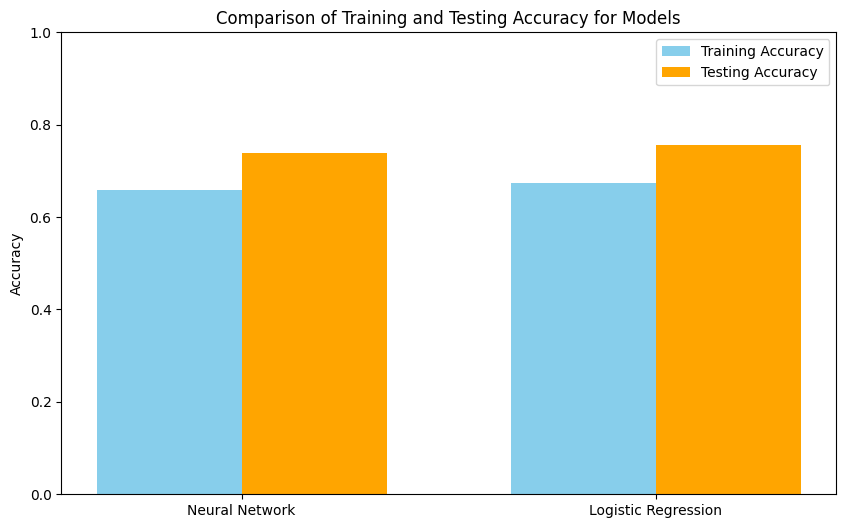

In [ ]:
  # Plotting Training and Testing Accuracy for Neural Network and Logistic Regression
models = ['Neural Network', 'Logistic Regression']
training_accuracies = [train_accuracy, train_accuracy_lr]
testing_accuracies = [test_accuracy, test_accuracy_lr]

# Plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(models))

# Training accuracy bars
plt.bar(x - bar_width / 2, training_accuracies, bar_width, label='Training Accuracy', color='skyblue')

# Testing accuracy bars
plt.bar(x + bar_width / 2, testing_accuracies, bar_width, label='Testing Accuracy', color='orange')

# Add labels and title
plt.xticks(x, models)
plt.ylabel('Accuracy')
plt.title('Comparison of Training and Testing Accuracy for Models')
plt.ylim(0, 1)
plt.legend()

# Display the plot
plt.show()


**Neural Network:**

Training Accuracy: ~65.76%
Testing Accuracy: ~73.95%

**Logistic Regression:**

Training Accuracy: ~73.07%
Testing Accuracy: ~78.99%

***Observations:***

Both models achieve higher testing accuracy than training accuracy, indicating good generalization to unseen data.

Logistic Regression slightly outperforms the Neural Network on this dataset in both training and testing accuracies.

Trying with different hidden layer size

In [ ]:
# import numpy as np

# # Prepare the dataset for neural network input
# # Separate features and target variable
# #'treatment' is the target variable (predicting if the employee seeks treatment)
# X = encoded_data.drop(columns=['treatment']).values
# y = encoded_data['treatment'].values

# # Normalize the features
# X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))  #Scales all features to a range of 0 to 1 for faster convergence during training.

# # Split the dataset into training and testing sets
# def train_test_split(X, y, test_size=0.2, random_seed=42):
#     np.random.seed(random_seed)
#     indices = np.random.permutation(len(X))
#     test_size = int(len(X) * test_size)
#     test_indices, train_indices = indices[:test_size], indices[test_size:]
#     return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

# X_train, X_test, y_train, y_test = train_test_split(X, y)

# # Initialize neural network parameters
# def initialize_parameters(input_size, hidden_size, output_size):   #Input layer: Size = number of features.Hidden layer: Size = hidden_size (10 units).Output layer: Size = 1 (binary classification).

#     np.random.seed(42)
#     W1 = np.random.randn(input_size, hidden_size) * 0.01
#     b1 = np.zeros((1, hidden_size))
#     W2 = np.random.randn(hidden_size, output_size) * 0.01
#     b2 = np.zeros((1, output_size))
#     return W1, b1, W2, b2

# # Activation functions
# def sigmoid(z):
#     return 1 / (1 + np.exp(-z))

# def sigmoid_derivative(a):
#     return a * (1 - a)

# # Forward propagation
# def forward_propagation(X, W1, b1, W2, b2): #Computes the activations of the hidden layer (A1) and the output layer (A2).
#     Z1 = np.dot(X, W1) + b1
#     A1 = sigmoid(Z1)
#     Z2 = np.dot(A1, W2) + b2
#     A2 = sigmoid(Z2)
#     return Z1, A1, Z2, A2

# # Backward propagation
# def backward_propagation(X, y, Z1, A1, Z2, A2, W1, W2): #Calculates gradients (dW1, db1, dW2, db2) to update weights and biases using gradient descent.
#     m = X.shape[0]
#     dZ2 = A2 - y.reshape(-1, 1)
#     dW2 = np.dot(A1.T, dZ2) / m
#     db2 = np.sum(dZ2, axis=0, keepdims=True) / m
#     dA1 = np.dot(dZ2, W2.T)
#     dZ1 = dA1 * sigmoid_derivative(A1)
#     dW1 = np.dot(X.T, dZ1) / m
#     db1 = np.sum(dZ1, axis=0, keepdims=True) / m
#     return dW1, db1, dW2, db2

# # Train the neural network with loss and accuracy tracking
# def train_neural_network_with_metrics(X, y, hidden_size, learning_rate, epochs, print_every=100):
#     input_size = X.shape[1]
#     output_size = 1  # Binary classification
#     W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)

#     losses = []
#     accuracies = []

#     for epoch in range(epochs):
#         Z1, A1, Z2, A2 = forward_propagation(X, W1, b1, W2, b2)
#         dW1, db1, dW2, db2 = backward_propagation(X, y, Z1, A1, Z2, A2, W1, W2)

#         # Update weights and biases
#         W1 -= learning_rate * dW1
#         b1 -= learning_rate * db1
#         W2 -= learning_rate * dW2
#         b2 -= learning_rate * db2

#         # Compute loss (Binary Cross-Entropy)
#         m = X.shape[0]
#         loss = -np.sum(y * np.log(A2 + 1e-8) + (1 - y) * np.log(1 - A2 + 1e-8)) / m
#         losses.append(loss)

#         # Compute accuracy
#         y_pred = (A2 > 0.5).astype(int).flatten()
#         acc = accuracy(y, y_pred)
#         accuracies.append(acc)

#         # Print metrics every 'print_every' epochs
#         if (epoch + 1) % print_every == 0:
#             print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.4f}")

#     return W1, b1, W2, b2, losses, accuracies

# # Predict and evaluate accuracy
# def predict(X, W1, b1, W2, b2):
#     _, _, _, A2 = forward_propagation(X, W1, b1, W2, b2)
#     return (A2 > 0.5).astype(int)

# def accuracy(y_true, y_pred):
#     return np.mean(y_true == y_pred.flatten())

# # Train and test the model with metrics tracking
# hidden_size = 40
# learning_rate = 0.001
# epochs = 1000

# W1, b1, W2, b2, losses, accuracies = train_neural_network_with_metrics(
#     X_train, y_train, hidden_size, learning_rate, epochs, print_every=100
# )

# # Final predictions and accuracy
# train_accuracy = accuracy(y_train, predict(X_train, W1, b1, W2, b2))
# test_accuracy = accuracy(y_test, predict(X_test, W1, b1, W2, b2))

# print(f"Final Training Accuracy: {train_accuracy:.4f}")
# print(f"Final Testing Accuracy: {test_accuracy:.4f}")


Epoch 100/1000 - Loss: 321.3689, Accuracy: 0.6576
Epoch 200/1000 - Loss: 315.7637, Accuracy: 0.6576
Epoch 300/1000 - Loss: 312.5034, Accuracy: 0.6576
Epoch 400/1000 - Loss: 310.5937, Accuracy: 0.6576
Epoch 500/1000 - Loss: 309.4676, Accuracy: 0.6576
Epoch 600/1000 - Loss: 308.7998, Accuracy: 0.6576
Epoch 700/1000 - Loss: 308.4019, Accuracy: 0.6576
Epoch 800/1000 - Loss: 308.1640, Accuracy: 0.6576
Epoch 900/1000 - Loss: 308.0213, Accuracy: 0.6576
Epoch 1000/1000 - Loss: 307.9355, Accuracy: 0.6576
Final Training Accuracy: 0.6576
Final Testing Accuracy: 0.7395


Using tensorflow to apply NN

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4725 - loss: 0.7349 - val_accuracy: 0.5583 - val_loss: 0.6933
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5339 - loss: 0.7110 - val_accuracy: 0.6333 - val_loss: 0.6572
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5297 - loss: 0.6862 - val_accuracy: 0.7000 - val_loss: 0.6348
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6190 - loss: 0.6536 - val_accuracy: 0.7083 - val_loss: 0.6184
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6230 - loss: 0.6635 - val_accuracy: 0.7083 - val_loss: 0.6086
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6565 - loss: 0.6558 - val_accuracy: 0.7250 - val_loss: 0.6012
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6429 - loss: 0.6495 - val_accuracy: 0.7167 - val_loss: 0.5968
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6319 - loss: 0.6706 - val_accuracy: 0.7167 - 

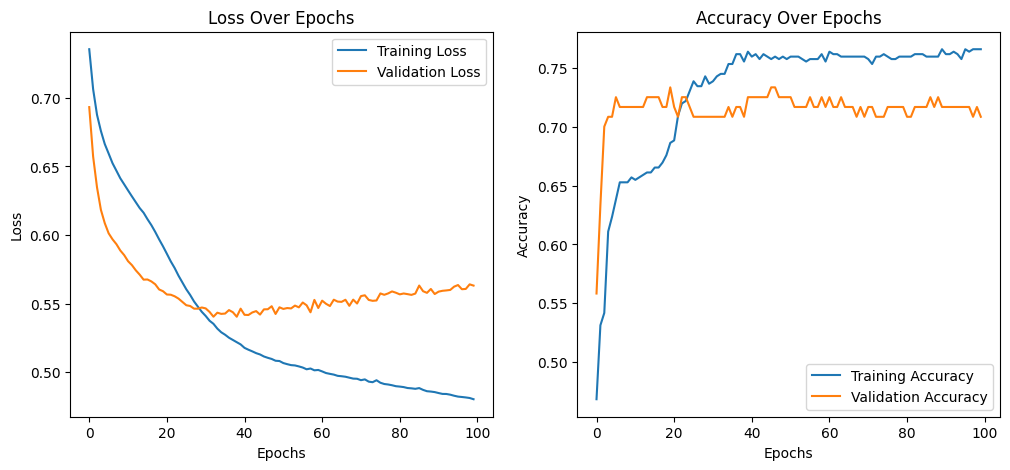

(0.76778244972229, 0.7083333134651184)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from sklearn.model_selection import train_test_split

# # Split data into training and testing sets using sklearn's train_test_split for consistency
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Build the Neural Network model
# model = Sequential([
#     Dense(10, input_dim=X_train.shape[1], activation='relu'),  # Hidden layer with 10 neurons and ReLU activation
#     Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model and capture the training history
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# # Evaluate final accuracy on training and testing datasets
# train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
# test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# # Plot loss and accuracy over epochs
# import matplotlib.pyplot as plt

# # Plot Loss
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Plot Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

# train_accuracy, test_accuracy


Using ReLU as an activation function

In [ ]:
# # ReLU activation function
# def relu(z):
#     return np.maximum(0, z)

# # Derivative of ReLU
# def relu_derivative(z):
#     return (z > 0).astype(float)

# # Forward propagation (with ReLU in the hidden layer)
# def forward_propagation(X, W1, b1, W2, b2):
#     Z1 = np.dot(X, W1) + b1
#     A1 = relu(Z1)  # ReLU activation for the hidden layer
#     Z2 = np.dot(A1, W2) + b2
#     A2 = sigmoid(Z2)  # Sigmoid activation for the output layer (binary classification)
#     return Z1, A1, Z2, A2

# # Backward propagation (with ReLU derivative in the hidden layer)
# def backward_propagation(X, y, Z1, A1, Z2, A2, W1, W2):
#     m = X.shape[0]
#     dZ2 = A2 - y.reshape(-1, 1)
#     dW2 = np.dot(A1.T, dZ2) / m
#     db2 = np.sum(dZ2, axis=0, keepdims=True) / m
#     dA1 = np.dot(dZ2, W2.T)
#     dZ1 = dA1 * relu_derivative(Z1)  # Derivative of ReLU for the hidden layer
#     dW1 = np.dot(X.T, dZ1) / m
#     db1 = np.sum(dZ1, axis=0, keepdims=True) / m
#     return dW1, db1, dW2, db2

# # Train and evaluate the model as before
# W1, b1, W2, b2, losses, accuracies = train_neural_network_with_metrics(
#     X_train, y_train, hidden_size, learning_rate, epochs, print_every=100
# )

# # Final predictions and accuracy
# train_accuracy = accuracy(y_train, predict(X_train, W1, b1, W2, b2))
# test_accuracy = accuracy(y_test, predict(X_test, W1, b1, W2, b2))

# print(f"Final Training Accuracy: {train_accuracy:.4f}")
# print(f"Final Testing Accuracy: {test_accuracy:.4f}")


Epoch 100/1000 - Loss: 330.1210, Accuracy: 0.6590
Epoch 200/1000 - Loss: 328.9859, Accuracy: 0.6590
Epoch 300/1000 - Loss: 327.9065, Accuracy: 0.6590
Epoch 400/1000 - Loss: 326.8801, Accuracy: 0.6590
Epoch 500/1000 - Loss: 325.9041, Accuracy: 0.6590
Epoch 600/1000 - Loss: 324.9757, Accuracy: 0.6590
Epoch 700/1000 - Loss: 324.0926, Accuracy: 0.6590
Epoch 800/1000 - Loss: 323.2526, Accuracy: 0.6590
Epoch 900/1000 - Loss: 322.4535, Accuracy: 0.6590
Epoch 1000/1000 - Loss: 321.6934, Accuracy: 0.6590
Final Training Accuracy: 0.6590
Final Testing Accuracy: 0.7333
